# 0 - Modules

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely import wkt

from os.path import exists
from os import makedirs

from matplotlib.colors import Normalize
import matplotlib.cm as cm
from matplotlib.cm import ScalarMappable

import unicodedata

import seaborn as sns


---

# 1 - Data Lecture

In our main dataset (birthPlaceRegion_sex), the 'Birth_Place_Region' column cointains the following nationalities:

<div style="display: flex; gap: 15px; flex-wrap: wrap;">
<div style="flex: 1; min-width: 200px;">

**Africa**
- Eastern Africa
- Middle Africa
- Northern Africa
- Southern Africa
- Western Africa

**America**
- Caribbean
- Central America
- Northern America
- South America

</div>
<div style="flex: 1; min-width: 200px;">

**Asia**
- Central Asia
- Eastern Asia
- Southern Asia
- South-Eastern Asia
- Western Asia

**Europe**
- Eastern Europe
- Northern Europe
- Southern Europe
- Western Europe

</div>
<div style="flex: 1; min-width: 200px;">

**Oceania**
- Australia and New Zealand
- Melanesia

**Others**
- Not available

</div>
</div>

Nevertheless, my team have decided to group them in the following way:

<div style="display: flex; gap: 20px; flex-wrap: wrap; justify-content: space-between;">
<div style="flex: 1; min-width: 250px;">

**Africa**
- Eastern Africa → Africa
- Middle Africa → Africa  
- Southern Africa → Africa
- Western Africa → Africa

**MENA**
- Northern Africa → MENA
- Western Asia → MENA

**Latin America**
- Caribbean → Latin America
- Central America → Latin America
- South America → Latin America

</div>
<div style="flex: 1; min-width: 250px;">

**Europe**
- Eastern Europe → Europe
- Northern Europe → Europe
- Southern Europe → Europe
- Western Europe → Europe

**NA-AUS-NZ**
- Australia and New Zealand → NA-AUS-NZ
- Northern America → NA-AUS-NZ
- Melanesia → NA-AUS-NZ

</div>
<div style="flex: 1; min-width: 250px;">

**Asia**
- Eastern Asia → Asia
- South-Eastern Asia → Asia
- Southern Asia → Asia
- Central Asia → Asia

</div>
</div>

Finally, it is very important to notice that the Spanish population is included in the 'Europe' group. However, since we are studying immigration in Cataluña, it is better to separate them from the rest of European, letting them to have their own category. We will be able to do that thanks to other dataset (birthPlace_spain_v_outside) in which the groups are the following:

<div style="display: flex; gap: 20px; flex-wrap: wrap; justify-content: space-between;">
<div style="flex: 1; min-width: 250px;">

**Spain**
- City of Barcelona → Spain
- Rest of Catalonia → Spain  
- Rest of Spain → Spain

</div>
<div style="flex: 1; min-width: 250px;">

**Immigrant**
- Rest of European Union → Immigrant
- Rest of World → Immigrant

</div>
</div>

Thus, we can distinguish between Spanish population and immigrants.

## 1.1 - Lecture including Spain as a separate category

In [50]:
def lecture_df(year, add_spain, level = 'Neighborhood'): # it returns a DataFrame with the number of people per grouped region

    # ------------------------------------------------------------------------------------------------

    # --- LOAD DATA --- (Birth Place DataFrame)

    data_dir = '../data/birthPlaceRegion/'
    file = f'{year}_birthPlaceRegion_sex.csv'
    df = pd.read_csv(data_dir + file)

    # --- CLEANING ---
    
    df['Value'] = pd.to_numeric(df['Value'], errors = 'coerce').fillna(0).astype(int) # convert to numeric, coerce errors to NaN, fill NaN with 0, convert to int
    df['Birth_Place_Region'] = df['Birth_Place_Region'].astype(str).str.strip() # ensure Birth_Place_Region is string and strip whitespace 

    #  --- IGNORE SEX ---

    df = df.groupby([level, 'Birth_Place_Region'], as_index = False)['Value'].sum()

    # --- GROUPING REGIONS ---

    region_map = {
        'Eastern Africa': 'Africa',
        'Middle Africa': 'Africa',
        'Southern Africa': 'Africa',
        'Western Africa': 'Africa',

        'Caribbean': 'Latin America',
        'Central America': 'Latin America',
        'South America': 'Latin America',

        'Northern Africa': 'MENA',
        'Western Asia': 'MENA',

        'Eastern Europe': 'Europe',
        'Northern Europe': 'Europe',
        'Southern Europe': 'Europe',
        'Western Europe': 'Europe',

        'Australia and New Zealand': 'NA-AUS-NZ',
        'Northern America': 'NA-AUS-NZ',
        'Melanesia': 'NA-AUS-NZ',

        'Eastern Asia': 'Asia',
        'South-Eastern Asia': 'Asia',
        'Central Asia': 'Asia',
        'Southern Asia': 'Asia'    
    }

    df['Group'] = df['Birth_Place_Region'].map(region_map).fillna('Other') # map regions to groups, fill unmapped with 'Other'

    # ------------------------------------------------------------------------------------------------

    # --- LOAD DATA --- (Spanish vs Immigrant DataFrame)

    data_dir2 = '../data/birthPlace_spain_v_outside/'
    file2 = f'{year}_birthPlace_spain_v_outside.csv'
    df2 = pd.read_csv(data_dir2 + file2)

    # --- CLEANING ---

    df2['Value'] = pd.to_numeric(df2['Value'], errors = 'coerce').fillna(0).astype(int) # convert to numeric, coerce errors to NaN, fill NaN with 0, convert to int
    df2['Birth_Place'] = df2['Birth_Place'].astype(str).str.strip() # ensure Birth_Place is string, strip whitespace

    # --- IGNORE SEX ---

    df2 = df2.groupby([level, 'Birth_Place'], as_index = False)['Value'].sum()

    # --- GROUPING REGIONS ---

    spanish_map = {
        'City of Barcelona': 'Spain',
        'Rest of Catalonia': 'Spain',
        'Rest of Spain': 'Spain',

        'Rest of European Union': 'Immigrant',
        'Rest of World': 'Immigrant',
    }

    df2['Group'] = df2['Birth_Place'].map(spanish_map).fillna('Other') # map birth places to groups, fill unmapped with 'Other'

    # ------------------------------------------------------------------------------------------------

    # --- SUBTRACT SPANISH FROM ORIGINAL DATAFRAME  --- (particularly, European Group)

    ## Total Spanish population per neighborhood

    spanish_df = df2[df2['Group'] == 'Spain'].groupby(level)['Value'].sum().reset_index() # get total Spanish counts per neighborhood
    spanish_df.rename(columns = {'Value': 'Spain_Value'}, inplace = True) # rename for clarity and ease to subtract

    ## Merge Spanish counts into df

    df = df.merge(spanish_df, on = level, how = 'left') 
    df['Spain_Value'] = df['Spain_Value'].fillna(0) # fill NaN with 0 

    # Subtract Spanish from Europe group

    mask_europe = df['Group'] == 'Europe' 
    df.loc[mask_europe, 'Value'] = df.loc[mask_europe, 'Value'] - df.loc[mask_europe, 'Spain_Value'] 

    # Avoid negative values due to imperfect grouping

    df['Value'] = df['Value'].clip(lower = 0) # just in case

    # --- ADD SPAIN AS A GROUP --- (CONDITIONAL)

    if add_spain:  
        spain_group = spanish_df.copy()
        spain_group['Group'] = 'Spain'
        spain_group.rename(columns={'Spain_Value': 'Value'}, inplace=True)

        df = pd.concat([df[[level, 'Group', 'Value']], 
                        spain_group[[level, 'Group', 'Value']]], 
                        ignore_index=True)

    # ------------------------------------------------------------------------------------------------
    
    absolute_groups = df.groupby([level, 'Group'], as_index = False)['Value'].sum() # final grouping

    return absolute_groups


def dictionary_df(year, add_spain, level = 'Neighborhood'): # same as above but in dictionary format with year as input

    # --- LOAD AND GROUP DATA ---

    df = lecture_df(year, add_spain, level = level)
    
    # --- CLEANING ---

    df[level] = df[level].astype(str).str.strip() # ensure level column is string and strip whitespace
    df['Group'] = df['Group'].astype(str).str.strip() # ensure Group column is string and strip whitespace
    df['Value'] = pd.to_numeric(df['Value'], errors = 'coerce').fillna(0).astype(int) # convert Value to numeric, coerce errors to NaN, fill NaN with 0, convert to int

    # --- CREATE DICTIONARY ---

    neighborhood_dict = {}
    for neighborhood in df[level].unique():
        sub_df = df[df[level] == neighborhood].drop(columns = [level])
        neighborhood_dict[neighborhood] = sub_df.reset_index(drop = True)

    return neighborhood_dict


In [51]:
def dictionary_df(year, add_spain, level = 'Neighborhood'): # same as above but in dictionary format with year as input

    # --- LOAD AND GROUP DATA ---

    df = lecture_df(year, add_spain, level = level)
    
    # --- CLEANING ---

    df[level] = df[level].astype(str).str.strip() # ensure level column is string and strip whitespace
    df['Group'] = df['Group'].astype(str).str.strip() # ensure Group column is string and strip whitespace
    df['Value'] = pd.to_numeric(df['Value'], errors = 'coerce').fillna(0).astype(int) # convert Value to numeric, coerce errors to NaN, fill NaN with 0, convert to int

    # --- CREATE DICTIONARY ---

    neighborhood_dict = {}
    for neighborhood in df[level].unique():
        sub_df = df[df[level] == neighborhood].drop(columns = [level])
        neighborhood_dict[neighborhood] = sub_df.reset_index(drop = True)

    return neighborhood_dict

In [52]:
# # Test

# year = 2022
# add_spain = True

# data = dictionary_df(year, add_spain)
# display(data)

---

# 2 - Diversity Calculation

## 2.1 - QUESTION: What is the diversity of each neighborhood in Barcelona?

## 2.2 -PROCEDURE:

### 2.2.1 - Simpson's Diversity Index (D) and Dataframe Creation

We are going to use the Simpsons' Index ($D$) to calculate the diversity of nationalities in EACH NEIGHBORHOOD, which is defined as:

$$ D = \sum_{i=1}^{S} \left( \frac{n_i}{N} \right)^2 $$

Where:

- $ S $ is the total number of different nationalities
- $ n_i $ is the number of individuals of nationality $ i $
- $ N $ is the total number of individuals

Then, we can compute the Simpsons' Diversity Index ($D$) for each neighborhood as follows:

$$ \text{SDI} = 1 - \sum_{i=1}^{S} \left( \frac{n_i}{N} \right)^2 $$

It is important to notice that the value of SDI ranges from 0 to almost 1 (assymptotically), where a value close to 0 indicates low diversity (dominance of one or nationality) and a value close to 1 indicates high diversity (more even distribution among nationalities).

Thus, we are taking an ecological approach to measure diversity since this index is widely used in ecology to quantify biodiversity in a community.

In [53]:
# Simpson's Diversity Index Calculation

def simpsons_diversity_index(df): # it returns the simpsons diversity index given a dataframe

    N = df['Value'].sum()

    if N == 0:
        return 0  # avoid division by zero (just in case but not expected to happen)
    
    sum_pi_squared = sum((count / N) ** 2 for count in df['Value'])
    D = 1 - sum_pi_squared

    return D


Now, we need a function that, giving a year, read the correponding data and calculate the diversity index for each neighborhood.

In [54]:
def compute_neighborhood_diversity(lecture_function, add_spain, year): # it returns a dataframe with the diversity index per neighborhood given a year

    # --- LOAD DATA ---

    df_neighborhood = lecture_function(year, add_spain)  # returns dict: neighborhood -> DataFrame
    
    # --- COMPUTE SIMPSON'S DIVERSITY INDEX ---

    diversity_results = {} # initialize empty dictionary to store results

    for label_neighborhood, df in df_neighborhood.items(): # it  works over all the neighborhoods separately (different dataframes)
        diversity_index = simpsons_diversity_index(df)
        diversity_results[label_neighborhood] = diversity_index
    
    # --- CONVERT TO DATAFRAME ---

    diversity_df = pd.DataFrame(
        list(diversity_results.items()), 
        columns=['Neighborhood', 'Simpsons_Diversity_Index']
    )
    
    # --- SORT DESCENDING --- (to better visualize the most and least diverse neighborhoods)

    diversity_df = diversity_df.sort_values(
        by = 'Simpsons_Diversity_Index', 
        ascending = False
    ).reset_index(drop = True)
    
    return diversity_df


In [55]:
# # Test

# lecture_function = dictionary_df
# add_spain = True
# year = 2022

# data = compute_neighborhood_diversity(lecture_function, add_spain, year)
# display(data)

### 2.2.2 - Visualization (color map)

In [56]:

def prepare_gdf(lecture_function, add_spain, year): # it returns a geodataframe with the diversity index per neighborhood given a year

    # --- LOAD DATA ---

    df = compute_neighborhood_diversity(lecture_function, add_spain, year)  # columns: Neighborhood, Simpsons_Diversity_Index
    # ----------------------------------------------------------------------------------------------------------------------

    # --- GEOMETRY LOADING ---
    
    geometry_file = '../data/geometry/neighborhoods_geometry.csv'
    geometry_df = pd.read_csv(geometry_file)

    # --- CONVERT WKT STRINGS TO GEOMETRIES ---

    geometry_df['Geometry_etrs89'] = geometry_df['Geometry_etrs89'].apply(wkt.loads)

    # --- CLEANING ---
    geometry_df['Neighborhood'] = geometry_df['Neighborhood'].astype(str).str.strip() # ensure Neighborhood is string and strip whitespace
    geometry_df['Neighborhood'] = geometry_df['Neighborhood'].apply(lambda x: unicodedata.normalize('NFC', x)) # normalize unicode

    # --- CREATE GEODATAFRAME ---
    gdf = gpd.GeoDataFrame(
        geometry_df,
        geometry='Geometry_etrs89',
        crs='EPSG:25831'
    )

    # ----------------------------------------------------------------------------------------------------------------------

    # --- MERGE DATAFRAMES ---
    
    merged_gdf = gdf.merge(df, on='Neighborhood', how='left')
    
    # --- CLEANING ---

    merged_gdf['Simpsons_Diversity_Index'] = merged_gdf['Simpsons_Diversity_Index'].fillna(0) # fill missing diversity values with 0

    return merged_gdf


def plot_simpsons_index(lecture_function, add_spain, year, ax): # it plots the diversity index per neighborhood given a year
    global vmin, vmax

    gdf = prepare_gdf(lecture_function, add_spain, year)

    # --- NORMALIZATION ---

    norm = Normalize(vmin = vmin, vmax = vmax)

    #  --- PLOTTING ---

    gdf.plot(column = 'Simpsons_Diversity_Index',
             ax = ax,
             cmap = 'cividis',
             norm = norm,
             linewidth = 0.4,
             edgecolor = 'black')

    ax.axis('off')

    # --- CREATE COLORBAR ---

    sm = ScalarMappable(cmap = 'cividis', norm = norm) # creates scalar mappable for colorbar
    sm.set_array([])  

    return sm 


In [57]:
# # Test

# lecture_function = dictionary_df
# add_spain = True
# year = 2022

# df_merged = prepare_gdf(lecture_function, add_spain, year)
# display(df_merged)

## 2.3 - RESULTS

Our intention will be to create a plot with two maps side by side: one showing the diversity including Spain as a separate category and another one not inluding Spain at all. Thus, in the first map, we will study the global diversity of Barcelona neighborhoods, while in the second one, we will focus on the diversity among immigrants.

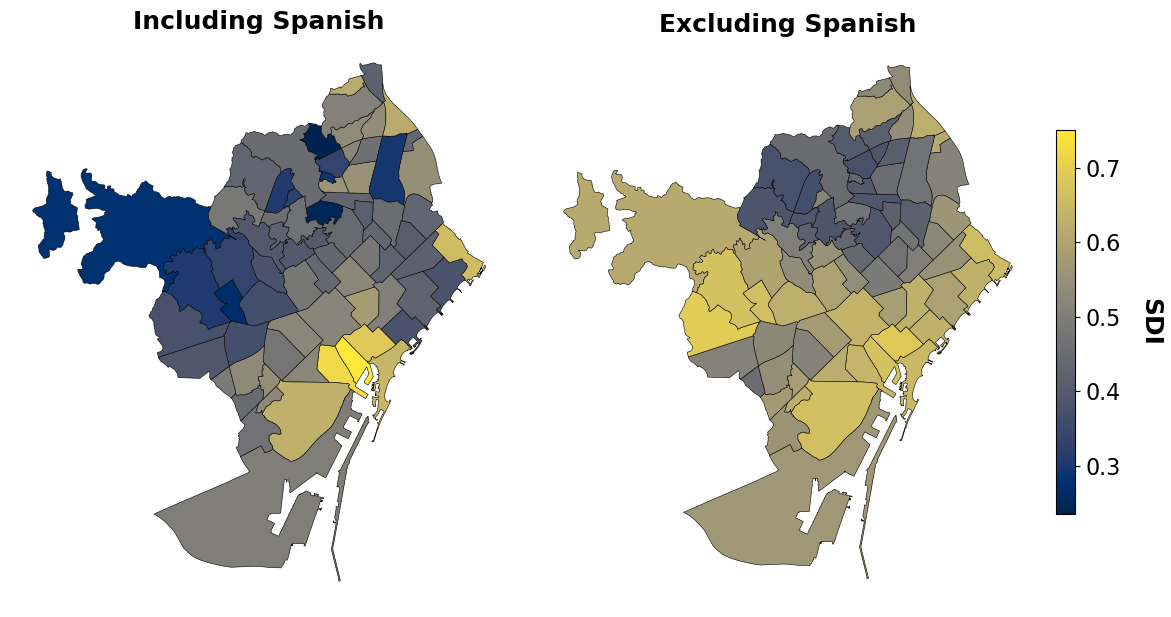

In [58]:
# CSV selection and loading

year = 2025
lecture_function = dictionary_df

# GeoDataFrames

df_merged_spain = prepare_gdf(lecture_function, True, year)
df_merged_no_spain = prepare_gdf(lecture_function, False, year)

# Global vmin and vmax for normalization

vmin = min(df_merged_spain['Simpsons_Diversity_Index'].min(), df_merged_no_spain['Simpsons_Diversity_Index'].min())
vmax = max(df_merged_spain['Simpsons_Diversity_Index'].max(), df_merged_no_spain['Simpsons_Diversity_Index'].max())

# Plotting

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 6))
sm1 = plot_simpsons_index(lecture_function, True, year, ax1)
sm2 = plot_simpsons_index(lecture_function, False, year, ax2)
ax1.set_title('Including Spanish', fontsize = 18, weight = 'bold')
ax2.set_title('Excluding Spanish', fontsize = 18, weight = 'bold')
# cbar1 = fig.colorbar(sm1, ax = ax1, fraction = 0.036, pad = 0.04)
# cbar1.set_label('Simpson\'s Diversity Index', fontsize = 12, weight = 'bold')
cbar2 = fig.colorbar(sm2, ax = ax2, fraction = 0.036, pad = 0.04)
cbar2.set_label('SDI', fontsize = 18, weight = 'bold', labelpad = 30, rotation = 270)
cbar2.ax.tick_params(labelsize = 16)


# plt.suptitle(f'Year = {year}', fontsize = 16, weight = 'bold')

plt.subplots_adjust(right=0.5) 

plt.tight_layout()
plt.show()


## 2.4 - CONCLUSIONS

- Rich Neighborhoods

In neighborhoods like Sarrià-Sant Gervasi or Les Corts, which are mainly inhabited by Spanish people, the SDI increases when excluding Spanish population since we are working with a small fraction of the total population. Therefore, the few nationalities are more evenly distributed, leading to a higher diversity value.

- Poor Neighborhoods

On the other hand, in neighborhoods like Raval, El Poblenou or La Barceloneta, which are known for their high diversity, the SDI remains high in both cases, indicating that these neighboorhoods have a more even distribution of nationalities, even when including Spanish population. In fact, in some cases, the SDI is lower since the removal of Spanish population takes away a group that contributed to the overall diversity.


## 2.5 - EXTRA: time evolution of diversity in neighborhoods between 1997 and 2025

In [59]:
def df_difference(lecture_function, add_spain, initial_year, final_year): # it returns a geodataframe with the difference in diversity index between two years

    # --- LOAD INITIAL AND FINAL DATA ---

    df_initial = prepare_gdf(lecture_function, add_spain, initial_year)[['Neighborhood', 'Simpsons_Diversity_Index']]
    df_final = prepare_gdf(lecture_function, add_spain, final_year)[['Neighborhood', 'Simpsons_Diversity_Index']]

    # --- COMPUTE DIFFERENCE --- (in Simpson's Diversity Index)

    df_diff = df_final.copy()
    df_diff['Diversity_difference'] = (df_final['Simpsons_Diversity_Index'] - df_initial['Simpsons_Diversity_Index']) / df_initial['Simpsons_Diversity_Index']
    df_diff['Diversity_difference'] = df_diff['Diversity_difference'].fillna(0)  # fill NaN values resulting from division by zero with 0
    df_diff = df_diff[['Neighborhood', 'Diversity_difference']]

    # ----------------------------------------------------------------------------------------------------------------------

    # --- GEOMETRY LOADING ---

    geometry_file = '../data/geometry/neighborhoods_geometry.csv'
    geometry_df = pd.read_csv(geometry_file)

    # --- CONVERT WKT STRINGS TO GEOMETRIES ---

    geometry_df['Geometry_etrs89'] = geometry_df['Geometry_etrs89'].apply(wkt.loads)

    # --- CLEANING ---

    geometry_df['Neighborhood'] = geometry_df['Neighborhood'].str.strip() # ensure Neighborhood is string and strip whitespace
    geometry_df['Neighborhood'] = geometry_df['Neighborhood'].apply(lambda x: unicodedata.normalize('NFC', x)) # normalize unicode

    # --- CREATE GEODATAFRAME ---

    gdf = gpd.GeoDataFrame(
        geometry_df,
        geometry='Geometry_etrs89',
        crs='EPSG:25831'
    )

    # ----------------------------------------------------------------------------------------------------------------------

    # --- MERGE DATAFRAMES ---

    gdf_diff = pd.merge(gdf, df_diff, on = 'Neighborhood', how = 'left')

    return gdf_diff


def plot_difference(lecture_function, add_spain,ax, initial_year, final_year, cmap='coolwarm'):
    global diff_vmax, diff_vmin

    # --- LOAD DIFFERENCE DATA ---

    gdf_diff = df_difference(lecture_function, add_spain, initial_year, final_year)

    # --- NORMALIZATION ---
    
    norm = Normalize(vmin = diff_vmin, vmax = diff_vmax)

    # --- MAP ---
    gdf_diff.plot(
        column = 'Diversity_difference',
        ax = ax,
        cmap = cmap,
        norm = norm,
        linewidth = 0.4,
        edgecolor = 'black'
    )

    ax.axis('off')
    
    # --- COLORBAR ---
    
    sm = ScalarMappable(cmap = cmap, norm = norm) # creates scalar mappable for colorbar
    sm.set_array([])

    return sm



C:\Users\MSI\AppData\Local\Temp\ipykernel_18260\2265895159.py:70: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


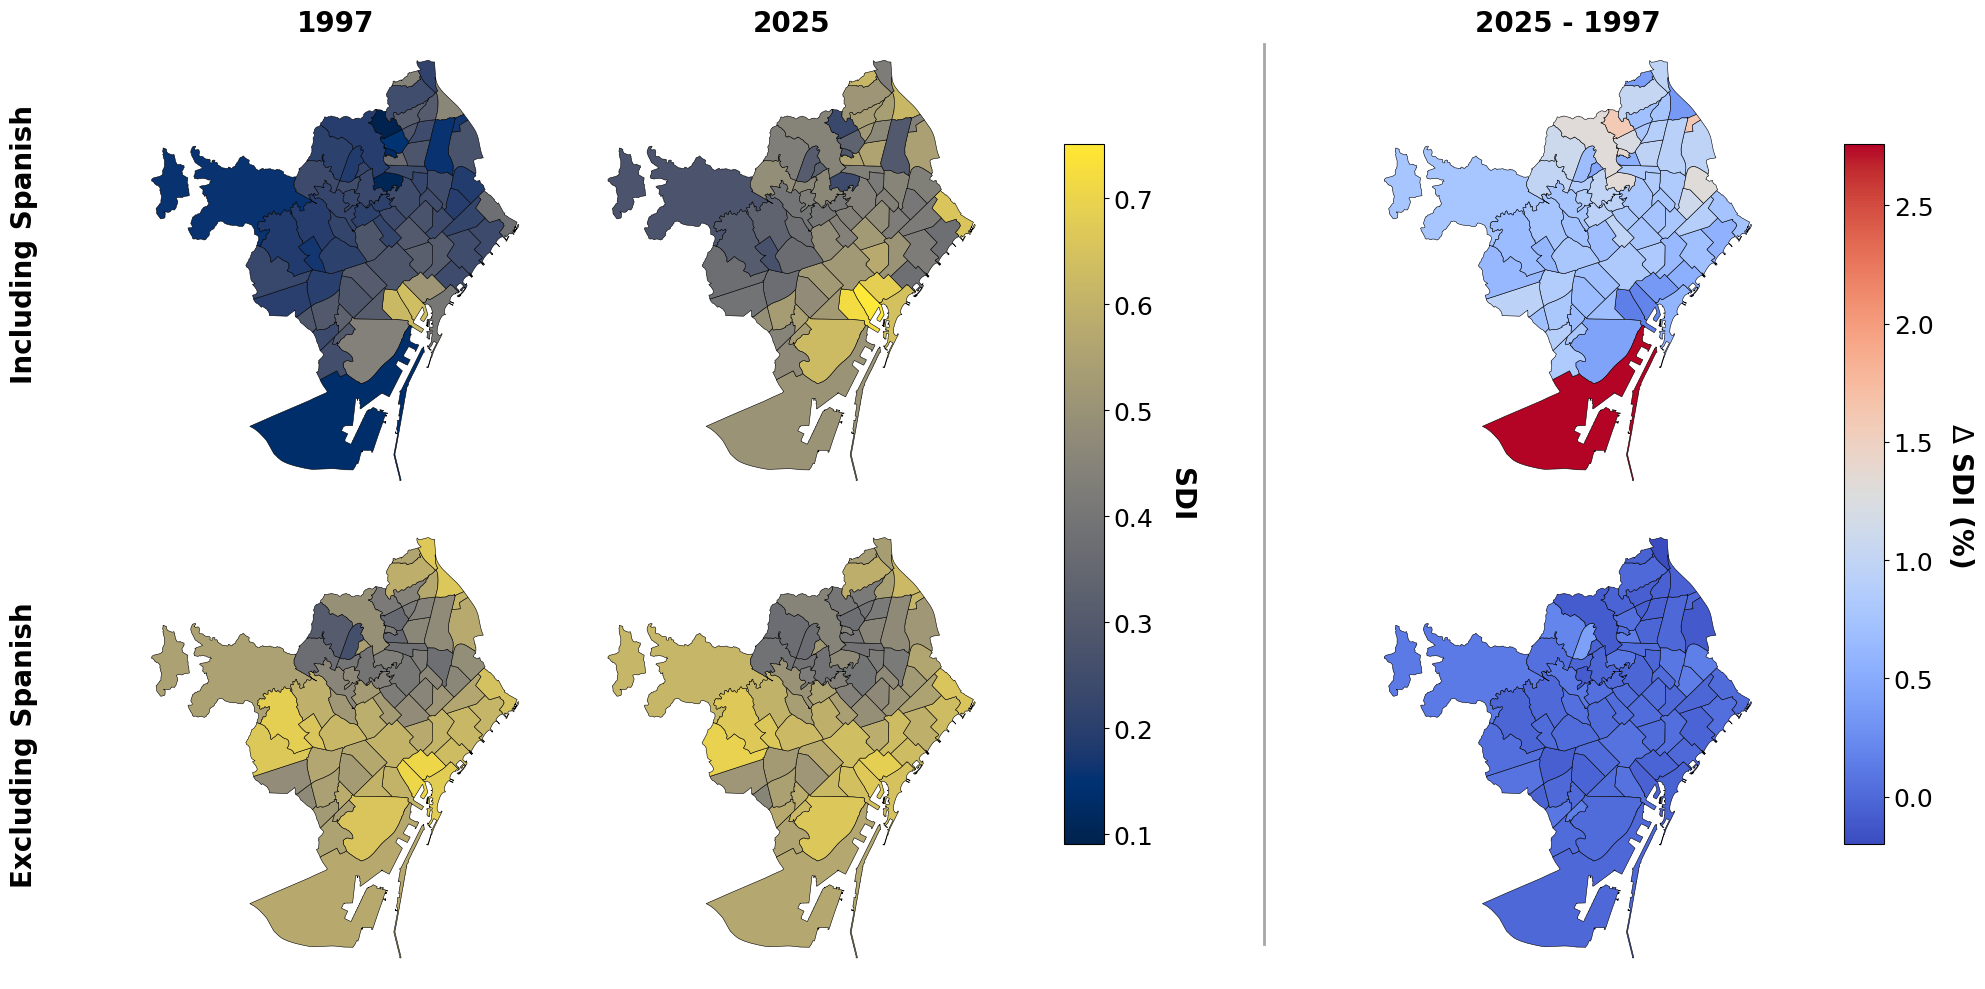

In [60]:
# CSV selection
years = [1997, 2025]

lecture_function = dictionary_df

# DataFrames
df_years_spain = {year: prepare_gdf(lecture_function, True, year) for year in years}  
df_years_no_spain = {year: prepare_gdf(lecture_function, False, year) for year in years}  

df_diff_spain = df_difference(lecture_function, True, years[0], years[1])
df_diff_no_spain = df_difference(lecture_function, False, years[0], years[1])

# Maps for each year with a common color scale
vmin_spain = min(df_years_spain[year]['Simpsons_Diversity_Index'].min() for year in years)
vmax_spain = max(df_years_spain[year]['Simpsons_Diversity_Index'].max() for year in years)

vmin_no_spain = min(df_years_no_spain[year]['Simpsons_Diversity_Index'].min() for year in years)
vmax_no_spain = max(df_years_no_spain[year]['Simpsons_Diversity_Index'].max() for year in years)

vmin = min(vmin_spain, vmin_no_spain)
vmax = max(vmax_spain, vmax_no_spain)

diff_min_spain = df_diff_spain['Diversity_difference'].min()
diff_max_spain = df_diff_spain['Diversity_difference'].max()
diff_min_no_spain = df_diff_no_spain['Diversity_difference'].min()
diff_max_no_spain = df_diff_no_spain['Diversity_difference'].max()

diff_vmin = min(diff_min_spain, diff_min_no_spain)
diff_vmax = max(diff_max_spain, diff_max_no_spain)

# Plotting
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
mappables = []

# --- ROW TITLES ---

fig.text(0.04, 0.75, 'Including Spanish', fontsize=20, weight='bold', ha='center', va='center', rotation=90)
fig.text(0.04, 0.25, 'Excluding Spanish', fontsize=20, weight='bold', ha='center', va='center', rotation=90)

# --- FIXED ORDERED LOOP ---
for i, year in enumerate(years):
    # Row 0: Including Spain
    sm1 = plot_simpsons_index(lecture_function, True, year, axes[0, i])
    mappables.append(sm1)
    axes[0, i].set_title(f'{year}', fontsize=20, weight='bold')
    
    # Row 1: Excluding Spain
    sm2 = plot_simpsons_index(lecture_function, False, year, axes[1, i])
    mappables.append(sm2)
    # axes[1, i].set_title(f'{year}', fontsize=20, weight='bold')

# Difference plots
sm_diff1 = plot_difference(lecture_function, True, axes[0, 2], years[0], years[1])
sm_diff2 = plot_difference(lecture_function, False, axes[1, 2], years[0], years[1])
axes[0, 2].set_title(f'{years[1]} - {years[0]}', fontsize=20, weight='bold')
# axes[1, 2].set_title(f'Difference\n({years[1]} - {years[0]})', fontsize=20, weight='bold')

# Shared colorbar for first 4 maps (positioned between columns 2-3-5-6)
cbar_ax1 = fig.add_axes([0.56, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
cbar1 = fig.colorbar(sm1, cax=cbar_ax1)
cbar1.set_label('SDI', fontsize=20, weight='bold', labelpad=30, rotation=270)
cbar1.ax.tick_params(labelsize=18)

# Shared colorbar for difference maps (positioned left of columns 3-6)
cbar_ax2 = fig.add_axes([0.95, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
cbar2 = fig.colorbar(sm_diff1, cax=cbar_ax2)
cbar2.set_label(r'$\Delta$ SDI (%)', fontsize=20, weight='bold', labelpad=30, rotation=270)
cbar2.ax.tick_params(labelsize=18)

plt.tight_layout()
plt.subplots_adjust(right=1)  # Make space for the colorbars

# Vertical grey divider between column 2025 (col=1) and Difference (col=2)
fig.add_artist(
    plt.Line2D(
        [0.66, 0.66],   # x-coordinates (fraction of figure width)
        [0.05, 0.95], # y-coordinates (fraction of figure height)
        color='grey',
        linewidth=2,
        alpha=0.7
    )
)

# -------------------------------------------------------
# SHIFT COLUMN 1 (the 2025 maps) SLIGHTLY LEFT
# -------------------------------------------------------
shift = -0.08   # adjust as needed (-0.02, -0.04, etc.)

for row in range(2):
    ax = axes[row, 1]      # column 1
    pos = ax.get_position()
    ax.set_position([pos.x0 + shift, pos.y0, pos.width, pos.height])

plt.show()

---

# 3 - Similarity between neighborhoods (social patterns organization)

## 3.1 - QUESTION: Giving some neighborhoods, how similar are them taking into account the share of nationalities in each neighborhood (percentage)?

Let's notice that with this method, there are several factors that can influence the results:

- Nationalities similarities
- Shares similarities (just by number -> social pattern organization) 
- We do not take into account the total population of each neighborhood in the measure of similarity

Therefore, the results should be interpreted with caution since they are not fully centered on cultural similarity.

## 3.2 - PROCEDURE:

We are going to use the cosine similarity method to calculate how similar the neighborhoods are, culturally speaking. That means that we have to take into account the nationality distribution in each neighborhood, not only the diversity index.

In order to do that, we will create a vector for each neighborhood, and in the overall, a matrix where:

- Rows -> Neighborhoods
- Columns -> Nationalities
- Values -> Percentage of each nationality 


In [61]:
def nationality_proportion_matrix_all(lecture_function, add_spain, year): # it returns a matrix with the nationality proportions per neighborhood

    # --- LOAD DATA ---

    df = lecture_function(year, add_spain)

    # Sort neighborhoods by diversity index

    diversity_df = compute_neighborhood_diversity(dictionary_df, add_spain, year)
    sorted_neighborhoods = diversity_df['Neighborhood'].tolist()

    df['Neighborhood'] = pd.Categorical(df['Neighborhood'], categories=sorted_neighborhoods, ordered=True)

    # --- PIVOT TO MATRIX --- (to have neighborhoods as rows and groups as columns)

    matrix = df.pivot(index = 'Neighborhood',
                      columns = 'Group',
                      values = 'Value').fillna(0)

    # --- CONVERT TO PROPORTIONS --- (to have proportions instead of absolute counts)

    matrix = matrix.div(matrix.sum(axis=1), axis=0)

    return matrix

Once we have this matrix, we can calculate the cosine similarity between neighborhoods using the following formula:

$$ \text{cosine\_similarity}(A, B) = \frac{A \cdot B}{||A|| \cdot ||B||} $$

In [62]:
from sklearn.metrics.pairwise import cosine_similarity

The main intention is to see if the order of the neighborhoods matters when visualizing the cosine similarity matrix as a heatmap (¿clusters?). Therefore, since our result will be sorted by SDI, we need a function that sorts the neighborhoods in a concrete order, for example, alphabetically. 

In [63]:
def sort_heatmap_alphabetically(heatmap_data):
    
    # Get neighborhood names
    neighborhoods = heatmap_data.index.tolist()
    
    # Sort alphabetically
    sorted_neighborhoods = sorted(neighborhoods)
    
    # Reindex both rows and columns to alphabetical order
    sorted_data = heatmap_data.reindex(index=sorted_neighborhoods, 
                                        columns=sorted_neighborhoods)
        
    return sorted_data

## 3.3 - RESULTS: 

In [64]:
year = 2025
lecture_function = lecture_df

### 3.3.1 - Including Spain (global similarity)

In [65]:
add_spain = True

In [66]:
# Diversity DataFrame

df_diversity_spain  = compute_neighborhood_diversity(dictionary_df, add_spain, year)
sorted_neighborhoods = df_diversity_spain['Neighborhood']

# Nationality Proportion Matrix

matrix_spain  = nationality_proportion_matrix_all(lecture_function, add_spain, year) # ordered by diversity index 

# Compute similarity matrix

cos_sim = cosine_similarity(matrix_spain.values)

cos_sim_df_spain = pd.DataFrame(
    cos_sim,
    index = matrix_spain.index,
    columns = matrix_spain.index
)


C:\Users\MSI\AppData\Local\Temp\ipykernel_18260\853934528.py:61: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap(cmap)
C:\Users\MSI\AppData\Local\Temp\ipykernel_18260\853934528.py:72: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])  # Leave space for the colorbar


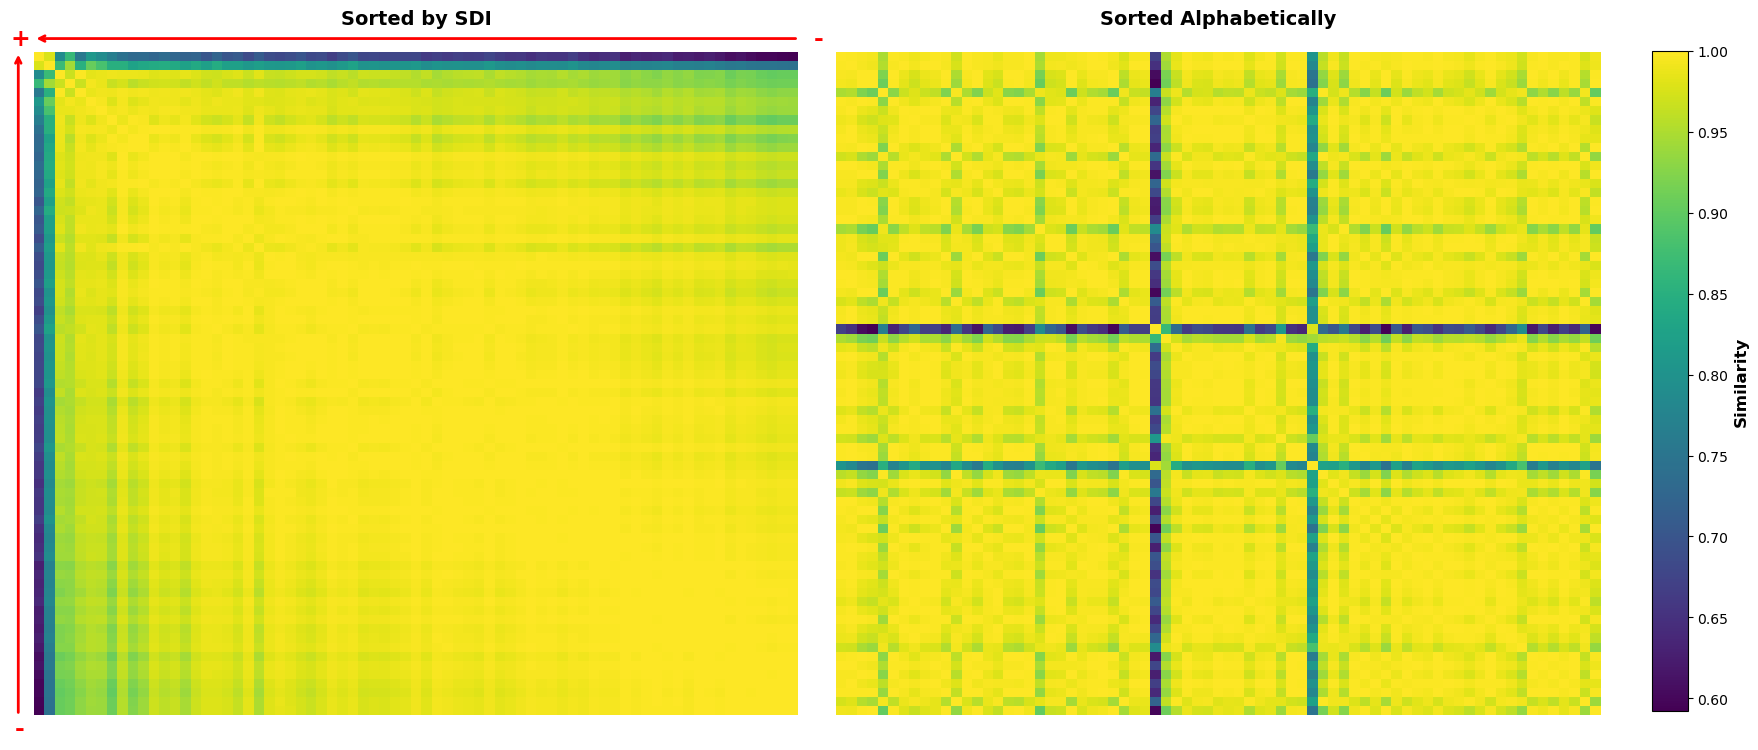

In [67]:
# Create figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8), sharey=True)
cmap = 'viridis'

# Sort the DataFrame alphabetically
cos_sim_df_sorted = sort_heatmap_alphabetically(cos_sim_df_spain)

# Find the min and max values for consistent color mapping
vmin = min(cos_sim_df_spain.values.min(), cos_sim_df_sorted.values.min())
vmax = max(cos_sim_df_spain.values.max(), cos_sim_df_sorted.values.max())

# LEFT SUBPLOT: Original order (NO colorbar)
heatmap1 = sns.heatmap(cos_sim_df_spain, 
            annot=False,
            cmap=  cmap,
            cbar=False,  # No colorbar on individual plot
            vmin=vmin, vmax=vmax,  # Consistent color range
            xticklabels=False,
            yticklabels=False,
            ax=ax1)

# Arrows for left subplot
ax1.annotate('', xy=(-0.02, 1), xytext=(-0.02, 0.0),
            xycoords='axes fraction', textcoords='axes fraction',
            arrowprops=dict(arrowstyle='->', color='red', lw=2))
ax1.annotate('', xy=(0, 1.02), xytext=(1, 1.02),
            xycoords='axes fraction', textcoords='axes fraction',
            arrowprops=dict(arrowstyle='->', color='red', lw=2))

ax1.text(-0.005, 1.02, '+', fontsize=17, weight='bold', color='red',
         ha='right', va='center', transform=ax1.transAxes)
ax1.text(1.02, 1.02, '-', fontsize=17, weight='bold', color='red',
         ha='left', va='center', transform=ax1.transAxes)
ax1.text(-0.025, -0.02, '-', fontsize=17, weight='bold', color='red',
         ha='left', va='center', transform=ax1.transAxes)

# ax1.set_xlabel('Neighborhoods', fontsize=12, weight='bold')
# ax1.set_ylabel('Neighborhoods', fontsize=12, weight='bold')
ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.set_title('Sorted by SDI', fontsize=14, weight='bold', pad=20)

# RIGHT SUBPLOT: Sorted alphabetically (NO colorbar)
heatmap2 = sns.heatmap(cos_sim_df_sorted, 
            annot=False,
            cmap=  cmap,
            cbar=False,  # No colorbar on individual plot
            vmin=vmin, vmax=vmax,  # Consistent color range
            xticklabels=False,
            yticklabels=False,
            ax=ax2) 

# ax2.set_xlabel('Neighborhoods', fontsize=12, weight='bold')
ax2.set_xlabel('') 
ax2.set_ylabel('')

ax2.set_title('Sorted Alphabetically', fontsize=14, weight='bold', pad=20)

# Create a single shared colorbar for both plots
# Get the colormap from one of the heatmaps
cmap = plt.cm.get_cmap(cmap)
norm = plt.Normalize(vmin=vmin, vmax=vmax)

# Add colorbar to the figure (not to individual axes)
cbar_ax = fig.add_axes([0.92, 0.054, 0.02, 0.825])  # [left, bottom, width, height]
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label('Similarity', fontsize=12, weight='bold')


plt.tight_layout(rect=[0, 0, 0.9, 0.95])  # Leave space for the colorbar
plt.show()

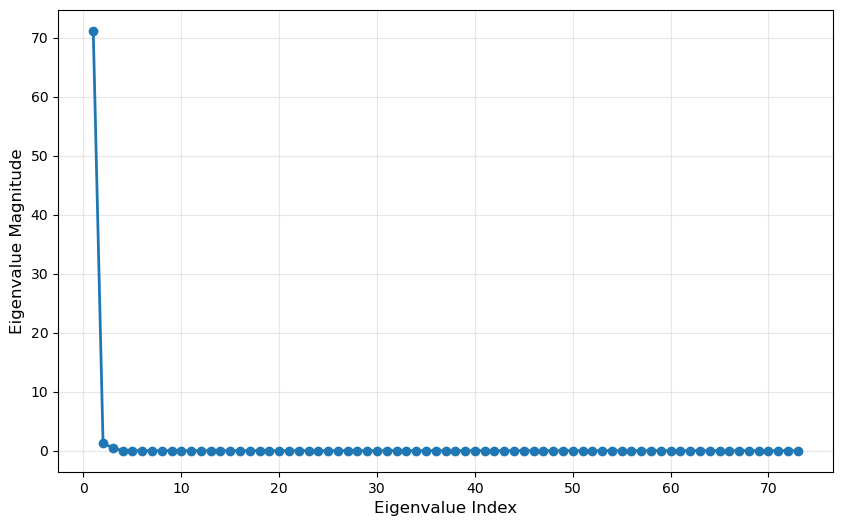

In [68]:
# Compute eigenvalues
eigenvalues = np.linalg.eigvalsh(cos_sim_df_spain)  # Use eigh for symmetric matrices
eigenvalues = np.sort(eigenvalues)[::-1]  # Sort descending

# Plot eigenvalue spectrum
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(eigenvalues)+1), eigenvalues, 'o-', linewidth=2)
# plt.axhline(y=1, color='r', linestyle='--', alpha=0.5, label='Random expectation')
plt.xlabel('Eigenvalue Index', fontsize=12)
plt.ylabel('Eigenvalue Magnitude', fontsize=12)
plt.grid(True, alpha=0.3)
# plt.legend()
plt.show()


### 3.3.2 - Excluding Spain (immigrant similarity)

In [69]:
add_spain = False

In [70]:
# Diversity DataFrame

df_diversity_no_spain  = compute_neighborhood_diversity(dictionary_df, add_spain, year)
sorted_neighborhoods = df_diversity_no_spain['Neighborhood']

# Nationality Proportion Matrix

matrix_no_spain  = nationality_proportion_matrix_all(lecture_function, add_spain, year) # ordered by diversity index 

# Compute similarity matrix

cos_sim = cosine_similarity(matrix_no_spain.values)

cos_sim_df_no_spain = pd.DataFrame(
    cos_sim,
    index = matrix_no_spain.index,
    columns = matrix_no_spain.index
)



C:\Users\MSI\AppData\Local\Temp\ipykernel_18260\352907055.py:61: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap(cmap)
C:\Users\MSI\AppData\Local\Temp\ipykernel_18260\352907055.py:72: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])  # Leave space for the colorbar


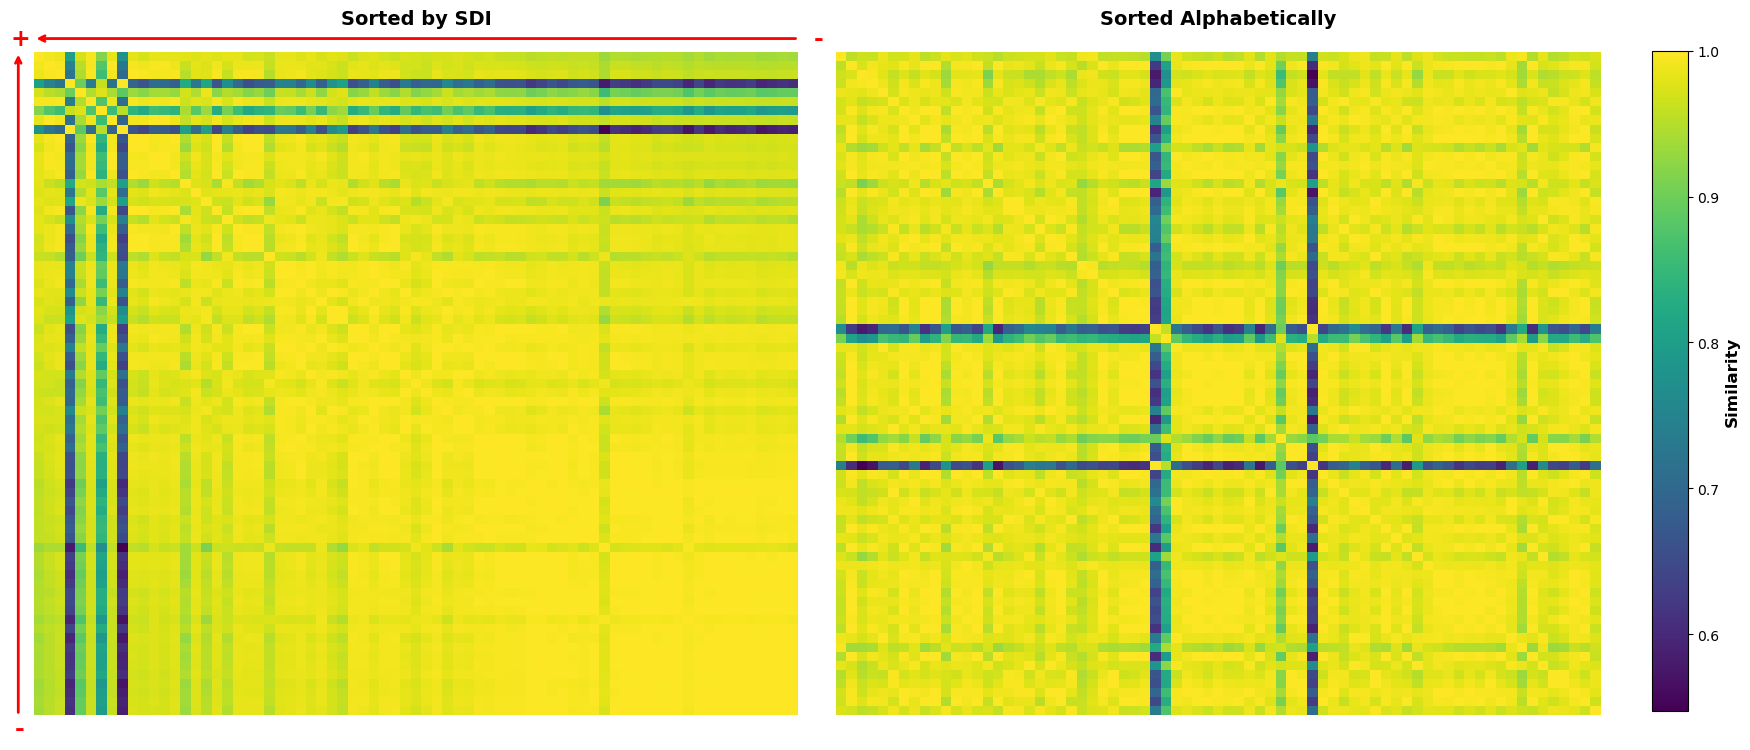

In [71]:
# Create figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8), sharey=True)
cmap = 'viridis'

# Sort the DataFrame alphabetically
cos_sim_df_sorted = sort_heatmap_alphabetically(cos_sim_df_no_spain)

# Find the min and max values for consistent color mapping
vmin = min(cos_sim_df_no_spain.values.min(), cos_sim_df_sorted.values.min())
vmax = max(cos_sim_df_no_spain.values.max(), cos_sim_df_sorted.values.max())

# LEFT SUBPLOT: Original order (NO colorbar)
heatmap1 = sns.heatmap(cos_sim_df_no_spain, 
            annot=False,
            cmap=  cmap,
            cbar=False,  # No colorbar on individual plot
            vmin=vmin, vmax=vmax,  # Consistent color range
            xticklabels=False,
            yticklabels=False,
            ax=ax1)

# Arrows for left subplot
ax1.annotate('', xy=(-0.02, 1), xytext=(-0.02, 0.0),
            xycoords='axes fraction', textcoords='axes fraction',
            arrowprops=dict(arrowstyle='->', color='red', lw=2))
ax1.annotate('', xy=(0, 1.02), xytext=(1, 1.02),
            xycoords='axes fraction', textcoords='axes fraction',
            arrowprops=dict(arrowstyle='->', color='red', lw=2))

ax1.text(-0.005, 1.02, '+', fontsize=17, weight='bold', color='red',
         ha='right', va='center', transform=ax1.transAxes)
ax1.text(1.02, 1.02, '-', fontsize=17, weight='bold', color='red',
         ha='left', va='center', transform=ax1.transAxes)
ax1.text(-0.025, -0.02, '-', fontsize=17, weight='bold', color='red',
         ha='left', va='center', transform=ax1.transAxes)

# ax1.set_xlabel('Neighborhoods', fontsize=12, weight='bold')
# ax1.set_ylabel('Neighborhoods', fontsize=12, weight='bold')
ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.set_title('Sorted by SDI', fontsize=14, weight='bold', pad=20)

# RIGHT SUBPLOT: Sorted alphabetically (NO colorbar)
heatmap2 = sns.heatmap(cos_sim_df_sorted, 
            annot=False,
            cmap=  cmap,
            cbar=False,  # No colorbar on individual plot
            vmin=vmin, vmax=vmax,  # Consistent color range
            xticklabels=False,
            yticklabels=False,
            ax=ax2) 

# ax2.set_xlabel('Neighborhoods', fontsize=12, weight='bold')
ax2.set_xlabel('') 
ax2.set_ylabel('')

ax2.set_title('Sorted Alphabetically', fontsize=14, weight='bold', pad=20)

# Create a single shared colorbar for both plots
# Get the colormap from one of the heatmaps
cmap = plt.cm.get_cmap(cmap)
norm = plt.Normalize(vmin=vmin, vmax=vmax)

# Add colorbar to the figure (not to individual axes)
cbar_ax = fig.add_axes([0.92, 0.054, 0.02, 0.825])  # [left, bottom, width, height]
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label('Similarity', fontsize=12, weight='bold')


plt.tight_layout(rect=[0, 0, 0.9, 0.95])  # Leave space for the colorbar
plt.show()

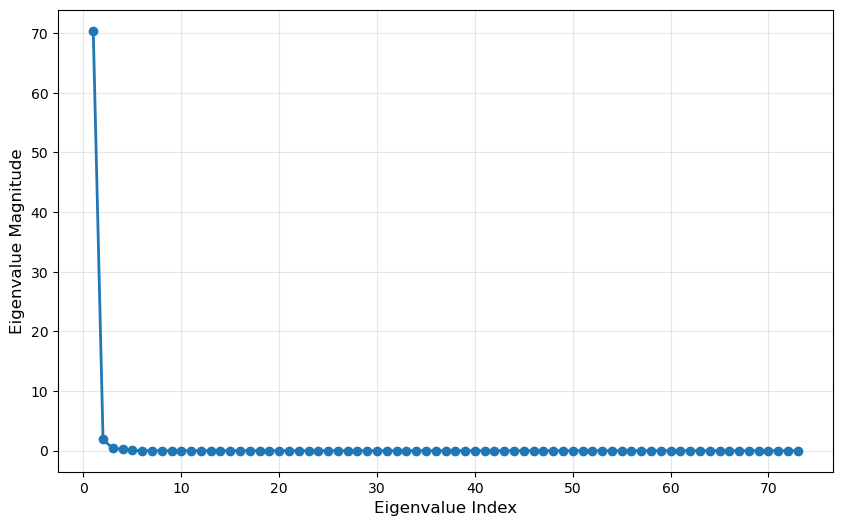

In [72]:
# Compute eigenvalues
eigenvalues = np.linalg.eigvalsh(cos_sim_df_no_spain)  # Use eigh for symmetric matrices
eigenvalues = np.sort(eigenvalues)[::-1]  # Sort descending

# Plot eigenvalue spectrum
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(eigenvalues)+1), eigenvalues, 'o-', linewidth=2)
# plt.axhline(y=1, color='r', linestyle='--', alpha=0.5, label='Random expectation')
plt.xlabel('Eigenvalue Index', fontsize=12)
plt.ylabel('Eigenvalue Magnitude', fontsize=12)
plt.grid(True, alpha=0.3)
# plt.legend()
plt.show()


## 4 - Similarity between neighborhoods (Cultural)

## 4.1 - QUESTION: Giving some neighborhoods, how similar are them culturally talking? 

Let's notice that with this method we just take into account the nationalities present in each neighborhood, not their shares. 

In this study, we will exclude Spanish population since we want to focus in the kind of immigration that each neighborhood has.

## 4.2 - PROCEDURE: Jaccard Similarity